In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/#Университет/Курс по ИИ 2024/Обработка видео 2024

!pip install cache-magic
import cache_magic
!mkdir .cache
!ln -s '/content/drive/MyDrive/#Университет/Курс по ИИ 2024/Обработка видео 2024/.cache' /content/.cache

Mounted at /content/drive/
/content/drive/MyDrive/#Университет/Курс по ИИ 2024/Обработка видео 2024
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00
  Created wheel for cache-magic: filename=cache_magic-1.0.4-py3-none-any.whl size=6681 sha256=a20d99aa2a514578bb885d1ca054aca185de0a94dfd4f82645274d1712f29a47
  Stored in directory: /root/.cache/pip/wheels/d9/f7/f4/24bcab40b8727b126e25c45abab8eb3b4b811f0674b18f0e7e
Successfully built cache-magic
mkdir: cannot create directory ‘.cache’: File exists


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

##Cellpose

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.82
    Uninstalling opencv-python-headless-4.10.0.82:
      Successfully uninstalled opencv-python-headless-4.10.0.82
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.9/204.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 8.5 MB/s eta 0:00:00
  Using cached nvidia_c

In [ ]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Mon Jun 17 17:10:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              12W /  7

In [ ]:
from cellpose import denoise, io
from cellpose import plot

In [ ]:
import cv2

# i_frames is sorted
def get_frames(video, i_frames, thresholding=False, threshold=75):
  if type(video) is str:
    cap = cv2.VideoCapture(video)
  else:
    cap = video
  i_frame = 0
  frames = []
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print('Видео закончилось')
      break
    if i_frame in i_frames:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = 1. - np.reshape(image, (1, image.shape[0],  image.shape[1])) / 255.
      if thresholding:
        image = image * (image > (threshold / 255))
      frames.append(image)
    i_frame += 1
    if len(frames) == len(i_frames):
      return frames

Общая площадь клеток: 323164
Кол-во клеток: 2671
Площадь одной клетки: 120.98989142643205
Средний диаметр:  6.21 пкс


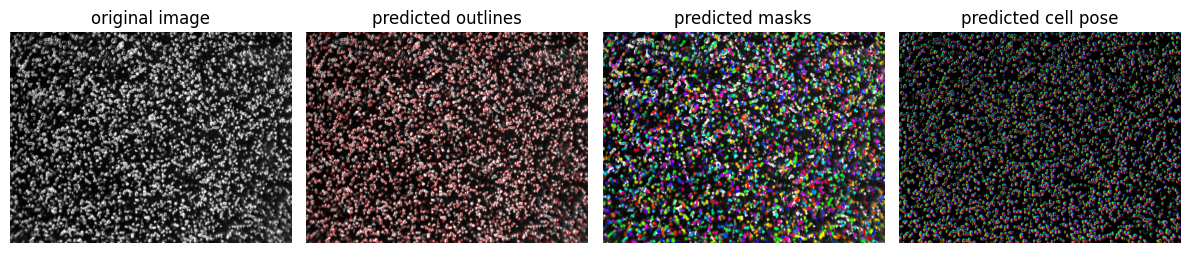

Общая площадь клеток: 132846
Кол-во клеток: 1261
Площадь одной клетки: 105.34972244250595
Средний диаметр:  5.79 пкс


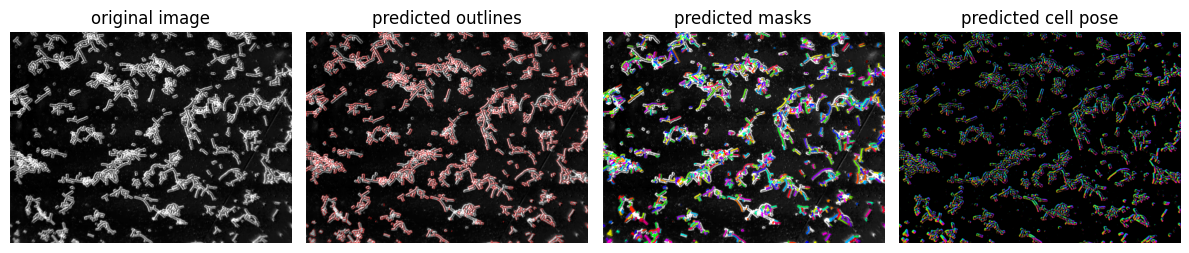

In [ ]:
io.logger_setup()
model = denoise.CellposeDenoiseModel(gpu=True, model_type="bact_fluor_cp3", restore_type="deblur_nuclei")
cap = cv2.VideoCapture("1.mp4")
last_frame_i = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
imgs = get_frames(cap, [0, last_frame_i])

masks, flows, styles, imgs_dn = model.eval(imgs, diameter=None, channels=[0,0])

nimg = len(imgs)
for idx in range(nimg):
  maski = masks[idx]
  flowi = flows[idx][0]

  number = maski.max()
  area = (maski != 0).sum()
  area_of_one = area / number
  diam = np.sqrt(area_of_one / np.pi)
  print(f"Общая площадь клеток: {area}\nКол-во клеток: {number}\nПлощадь одной клетки: {area_of_one}\nСредний диаметр: {diam: .2f} пкс")

  fig = plt.figure(figsize=(12,5))
  plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=[0,0])
  plt.tight_layout()
  plt.show()

###Обработка всего видео с помощью Cellpose

[cache-magic](https://pypi.org/project/cache-magic/)


In [ ]:
from tqdm.notebook import trange, tqdm

In [ ]:
io.logger_setup()
model = denoise.CellposeDenoiseModel(gpu=True, model_type="nuclei", restore_type="upsample_nuclei")
cap = cv2.VideoCapture("1.mp4")
fps = float(cap.get(cv2.CAP_PROP_FPS))
frame_time = 1 / fps
print(f"FPS: {fps:.3f}")
last_frame_i = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
i_frame = 0
step = 5
all_frames_indx = list(range(0, last_frame_i + 1, step))
# video1_cellposed = {"masks" : [], "flows" : [], "styles" : [], "imgs_dn" : []}
video1_masks = []
video1_times = []

with tqdm(total=len(all_frames_indx)) as pbar:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print('Видео закончилось')
            break

        if not i_frame in all_frames_indx:
            i_frame += 1
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = 1. - np.reshape(image, (1, image.shape[0],  image.shape[1])) / 255.
        mask, flow, style, imgs_dn = model.eval([image], diameter=10, channels=[0,0])
        video1_masks.append(mask[0])
        video1_times.append(frame_time * i_frame)
        # video1_cellposed["masks"].append(mask[0])
        # video1_cellposed["flows"].append(flow[0])
        # video1_cellposed["styles"].append(style[0])
        # video1_cellposed["imgs_dn"].append(imgs_dn[0])
        i_frame += 1
        pbar.update(1)

FPS: 29.970


  0%|          | 0/285 [00:00<?, ?it/s]

Видео закончилось


In [ ]:
video1_data = {"masks" : video1_masks, "times" : video1_times}

In [ ]:
%cache video1_data_nuclei = video1_data

Creating new value for variable 'video1_data_nuclei'


In [ ]:
%cache video1_data_nuclei # результат модели nuclei, upsample_nuclei

Loading cached value for variable 'video1_data_nuclei'. Time since caching: 4:46:14.244812


In [ ]:
%cache video1_data # результат модели bact_fluor_cp3, deblur_nuclei

Loading cached value for variable 'video1_data'. Time since caching: 10 days, 8:15:56.048213


In [ ]:
%cache

#Методы кластеризации


[Их дофига](https://scikit-learn.org/stable/api/sklearn.cluster.html)

[Плюс, метрики](https://education.yandex.ru/handbook/ml/article/klasterizaciya)

In [ ]:
masks = video1_data_nuclei['masks']
times = video1_data_nuclei['times']
mask_max_idx = len(masks) - 1

NameError: name 'video1_data_nuclei' is not defined

In [ ]:
masks = video1_data['masks']
times = video1_data['times']
mask_max_idx = len(masks) - 1

In [ ]:
def mask2center_coords(mask):
    mask = mask.T
    number = mask.max() # кол-во клеток
    coords = np.zeros((number, 2))
    for i in range(1, number + 1): # 0 - это фон
        bool_mask = mask == i
        area = (bool_mask).sum()
        indexes = np.where(bool_mask)
        coords[i-1][0] = indexes[0].sum() / area
        coords[i-1][1] = indexes[1].sum() / area
    return coords


def mask2all_coords(mask):
    mask = mask.T
    indexes = np.where(mask != 0)
    indexes = np.array(indexes)
    number = indexes.shape[1]
    coords = np.zeros((number, 2))
    coords[:, 0] = indexes[0, :]
    coords[:, 1] = indexes[1, :]
    return coords

##DBSCAN

Воспользуемся DBSCAN для кластеризации, чтобы правильно рассчитать кол-во клеток в агрегатах и получить похожий график.

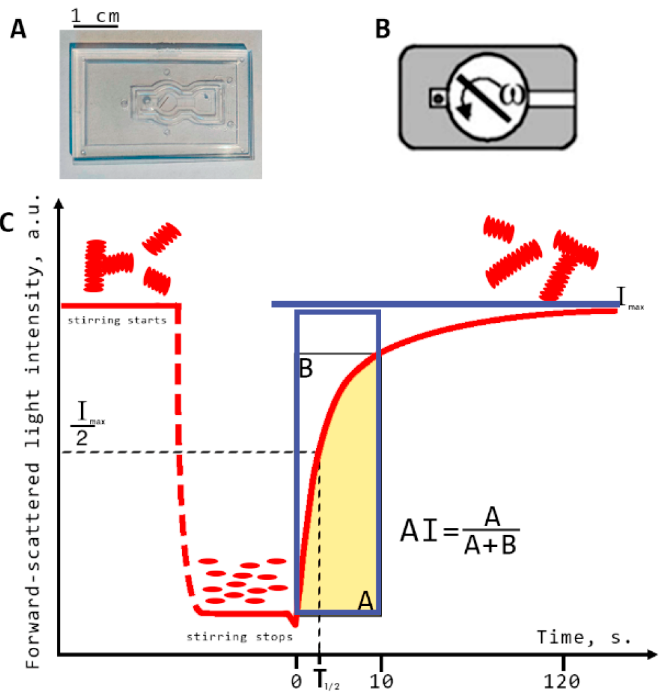

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

### Разделение по центрам

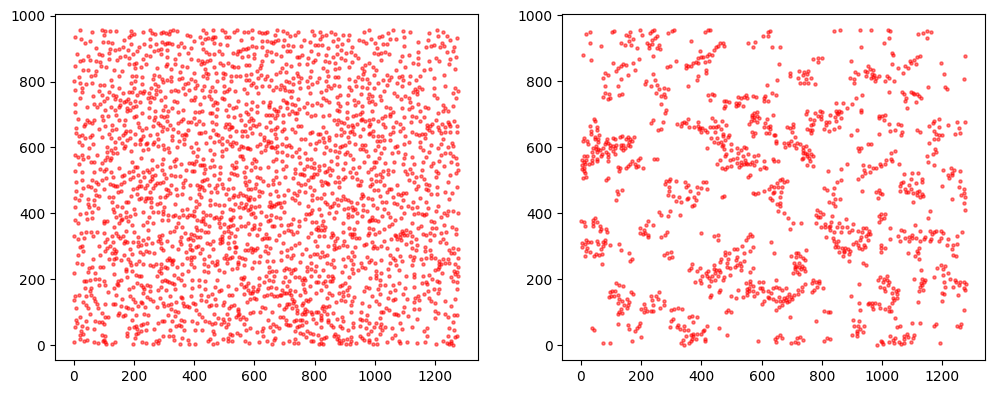

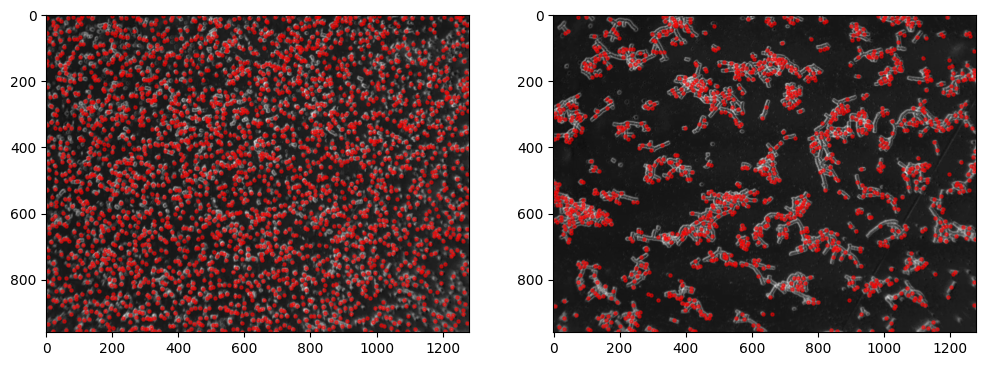

In [ ]:
# получим координаты клеток в начале и в конце
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
coords_2frames = []
for framei in range(2):
    mask = masks[framei].T
    number = mask.max() # кол-во клеток
    coords = np.zeros((number, 2))
    coords_2frames.append(coords)
    for i in range(1, number + 1): # 0 - это фон
        area = (mask == i).sum()
        indexes = np.where(mask == i)
        coords[i-1][0] = indexes[0].sum() / area
        coords[i-1][1] = indexes[1].sum() / area
    # axs[framei].imshow(imgs[framei][0], cmap='gray')
    axs[framei].scatter(coords[:, 0], coords[:, 1], c='r', s=5, alpha=0.5)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
coords_2frames = []
for framei in range(2):
    mask = masks[framei].T
    number = mask.max() # кол-во клеток
    coords = np.zeros((number, 2))
    coords_2frames.append(coords)
    for i in range(1, number + 1): # 0 - это фон
        area = (mask == i).sum()
        indexes = np.where(mask == i)
        coords[i-1][0] = indexes[0].sum() / area
        coords[i-1][1] = indexes[1].sum() / area
    axs[framei].imshow(imgs[framei][0], cmap='gray')
    axs[framei].scatter(coords[:, 0], coords[:, 1], c='r', s=5, alpha=0.5)
plt.show()

eps = 24.823304717732256, min_samples = 1


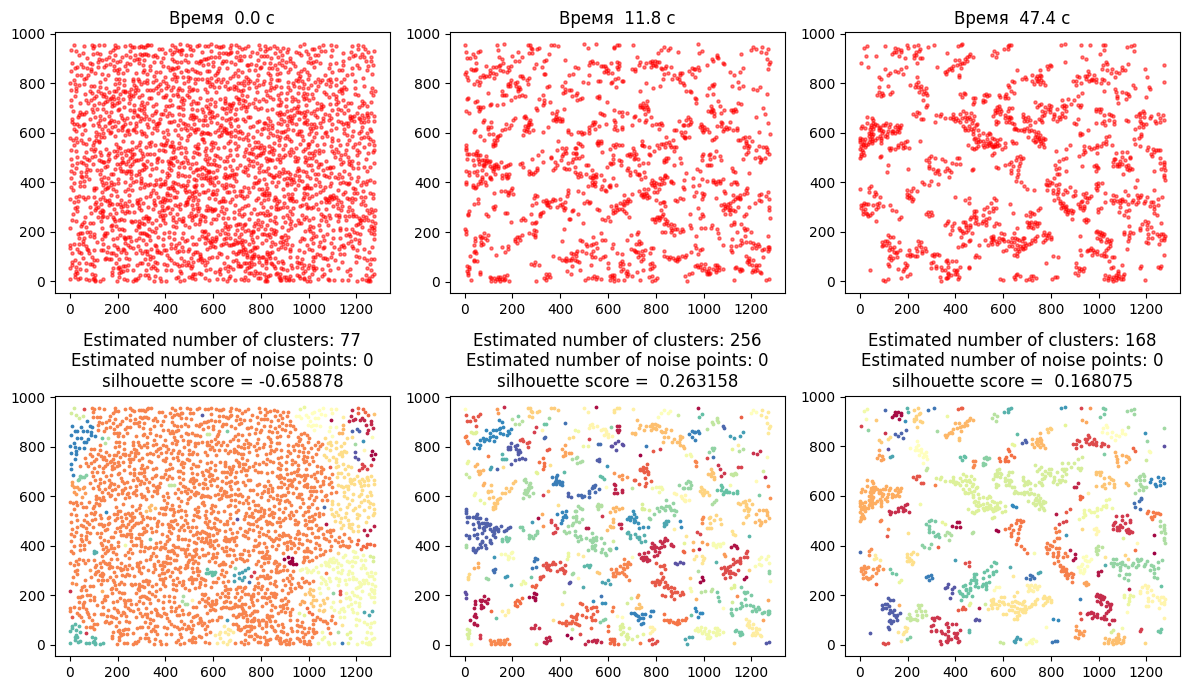

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

mask_0 = masks[0]
cells_number = mask_0.max()
cells_area = (mask_0 != 0).sum()
cell_area = cells_area / cells_number
diam = np.sqrt(cell_area / np.pi)

eps = diam * 4
min_samples = 1
print(f"eps = {eps}, min_samples = {min_samples}")

for column, i in enumerate([0, int(mask_max_idx / 4), mask_max_idx]):
    axs[0][column].set_title(f"Время {times[i] : .1f} с")
    coords = mask2center_coords(masks[i])
    axs[0][column].scatter(coords[:, 0], coords[:, 1], c='r', s=5, alpha=0.5)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(coords)
    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    np.random.shuffle(colors)
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = coords[class_member_mask & core_samples_mask]
        axs[1][column].scatter(
            xy[:, 0],
            xy[:, 1],
            color=tuple(col),
            s=3
        )

        xy = coords[class_member_mask & ~core_samples_mask]
        axs[1][column].scatter(
            xy[:, 0],
            xy[:, 1],
            color=tuple(col),
            s=3
        )

    sil_coeff = 0
    if len(unique_labels) > 1:
        sil_coeff = metrics.silhouette_score(coords, labels)

    axs[1][column].set_title(f"Estimated number of clusters: {n_clusters_}" + \
                             f"\nEstimated number of noise points: {n_noise_}" + \
                             f"\nsilhouette score = {sil_coeff : .6f}")

plt.tight_layout()
plt.show()

**Выводы**

Модель **bact_fluor_cp3** в целом неплохо выделяет клетки и даже выделяет длинные агрегаты... Но если агрегат длинный, то в нем много клеток, а потом учитываем только центр, будто это всего одна клетка. Неувязочка.

Т.е. надо учитывать кол-во клеток в длинной сардельке. Либо использовать только ту модель, которая выделяет клетки - это самый логичный вариант.


По старым результатам лучше всего справилась **модель nuclei (повышатель качества: upsample_nuclei)**.

Здесь новая модель (nuclei, upsample_nuclei)

eps = 47.37396715702304, min_samples = 1


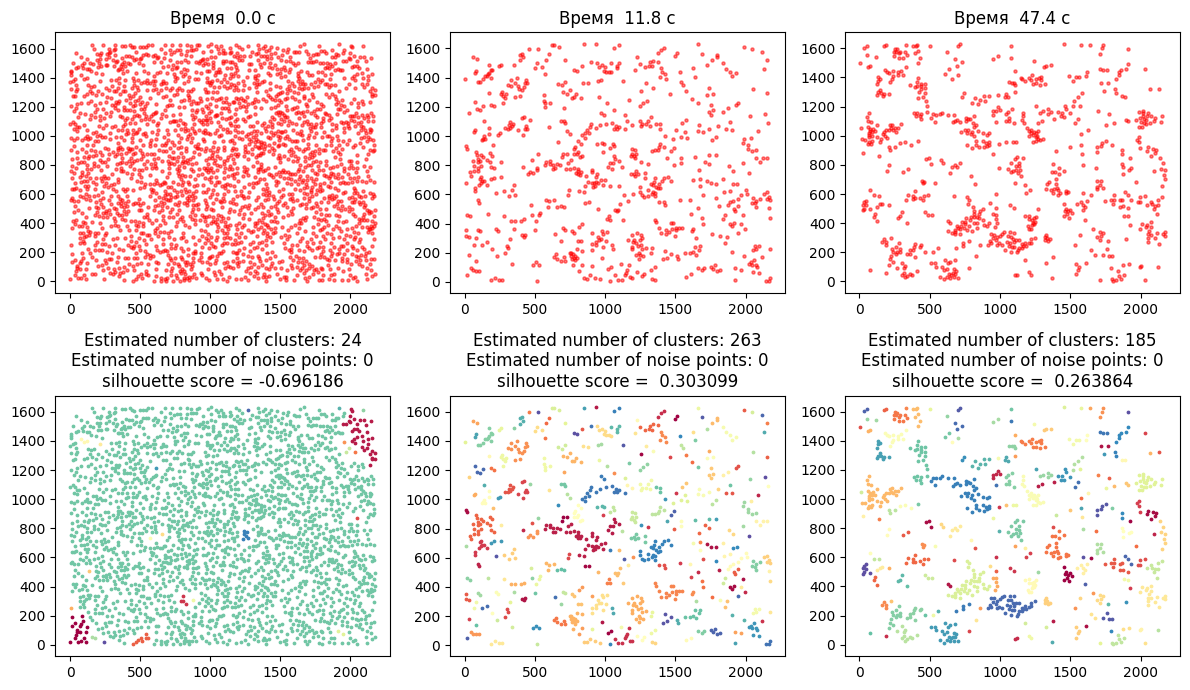

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

mask_0 = masks[0]
cells_number = mask_0.max()
cells_area = (mask_0 != 0).sum()
cell_area = cells_area / cells_number
diam = np.sqrt(cell_area / np.pi)

eps = diam * 5
min_samples = 1
print(f"eps = {eps}, min_samples = {min_samples}")

for column, i in enumerate([0, int(mask_max_idx / 4), mask_max_idx]):
    axs[0][column].set_title(f"Время {times[i] : .1f} с")
    coords = mask2center_coords(masks[i])
    axs[0][column].scatter(coords[:, 0], coords[:, 1], c='r', s=5, alpha=0.5)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(coords)
    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    np.random.shuffle(colors)
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = coords[class_member_mask & core_samples_mask]
        axs[1][column].scatter(
            xy[:, 0],
            xy[:, 1],
            color=tuple(col),
            s=3
        )

        xy = coords[class_member_mask & ~core_samples_mask]
        axs[1][column].scatter(
            xy[:, 0],
            xy[:, 1],
            color=tuple(col),
            s=3
        )

    sil_coeff = 0
    if len(unique_labels) > 1:
        sil_coeff = metrics.silhouette_score(coords, labels)

    axs[1][column].set_title(f"Estimated number of clusters: {n_clusters_}" + \
                             f"\nEstimated number of noise points: {n_noise_}" + \
                             f"\nsilhouette score = {sil_coeff : .6f}")

plt.tight_layout()
plt.show()

###Все видео

In [ ]:
av_num_in_clusters = np.zeros_like(times)
av_num_only_in_clusters = np.zeros_like(times)
sil_coeffs = np.zeros_like(times)

mask_0 = masks[0]
cells_number = mask_0.max()
cells_area = (mask_0 != 0).sum()
cell_area = cells_area / cells_number
diam = np.sqrt(cell_area / np.pi)

eps = diam * 5
min_samples = 1

for i in trange(0, mask_max_idx + 1):
    coords = mask2center_coords(masks[i])

    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(coords)
    labels = db.labels_
    unique_labels = set(labels)

    # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1) # эти клетки тоже важно учесть

    num_in_clusters = 0
    in_big_clasters = 0 # те клетки, которые живут скорее всего одни
    cluster_count = 0
    for label in unique_labels:
        if label == -1:
            continue
        cells_in_claster = (labels == label).sum()
        if cells_in_claster < cells_number / 3:
            num_in_clusters += cells_in_claster
            cluster_count += 1
        else:
            in_big_clasters += cells_in_claster
    av_num_in_cluster = (num_in_clusters + in_big_clasters + n_noise_) / (cluster_count + in_big_clasters + n_noise_)
    av_num_in_clusters[i] = av_num_in_cluster
    if cluster_count > 0:
        av_num_only_in_clusters[i] = num_in_clusters / cluster_count
    else:
        av_num_only_in_clusters[i] = 0

    sil_coeff = 0
    if len(unique_labels) > 1:
        sil_coeff = metrics.silhouette_score(coords, labels)
    sil_coeffs[i] = sil_coeff

  0%|          | 0/285 [00:00<?, ?it/s]

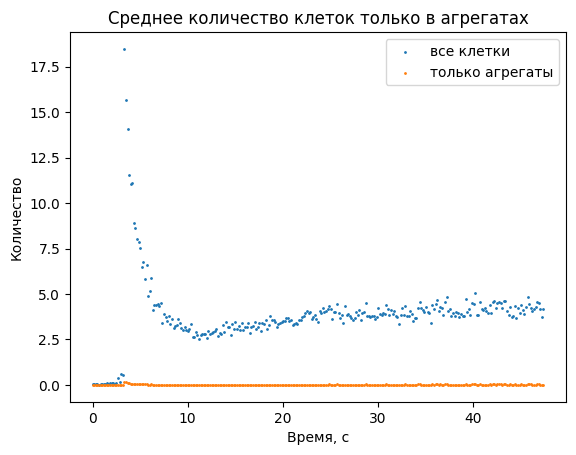

In [ ]:
plt.scatter(times, av_num_in_clusters, s=1)
plt.scatter(times, av_num_only_in_clusters, s=1)

plt.title("Среднее количество клеток только в агрегатах")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.legend(["все клетки", "только агрегаты"])
plt.show()

###Разделение целиком

In [ ]:
import numpy as np
import skimage.measure

In [ ]:
def squeeze(mask, n=2):
    return mask[::n, ::n]


def pool_2d(mask, n=2, method=np.max):
    return skimage.measure.block_reduce(mask, (n,n), method)


def unsqueeze(mask):
    pass

eps = 4.654369634574798, min_samples = 15


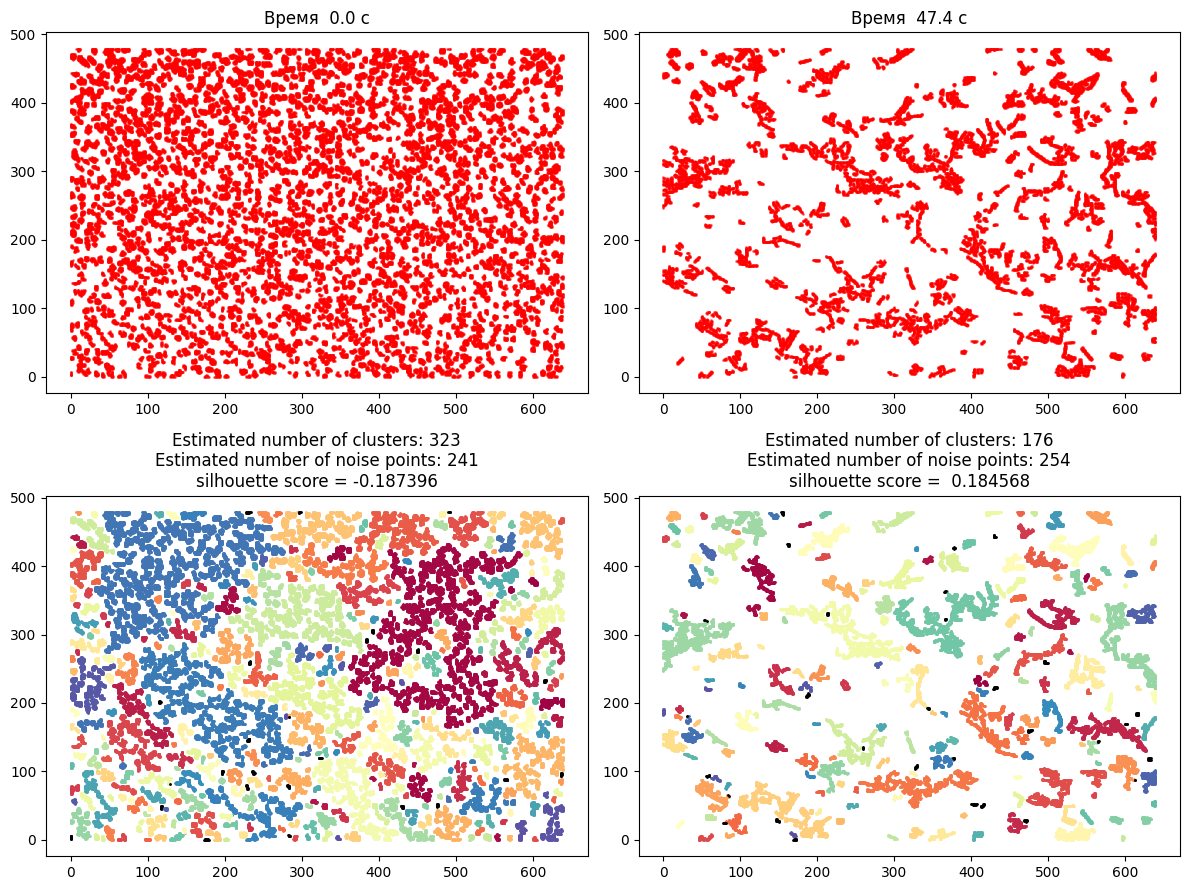

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

n = 2 # !
mask_0 = masks[0]
cells_number = mask_0.max()
cells_area = (mask_0 != 0).sum()
cell_area = cells_area / cells_number
diam = np.sqrt(cell_area / np.pi)
diam = diam / n
cell_area = cell_area / (n * n)

eps = diam * 1.5
min_samples = int(cell_area / 2)
print(f"eps = {eps}, min_samples = {min_samples}")

for column, i in enumerate([0, mask_max_idx]):
    axs[0][column].set_title(f"Время {times[i] : .1f} с")
    mask = masks[i]
    mask = squeeze(mask, n=n)
    coords = mask2all_coords(mask)
    axs[0][column].scatter(coords[:, 0], coords[:, 1], c='r', s=1, alpha=0.5)

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    np.random.shuffle(colors)
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = coords[class_member_mask & core_samples_mask]
        axs[1][column].scatter(
            xy[:, 0],
            xy[:, 1],
            color=tuple(col),
            s=1
        )

        xy = coords[class_member_mask & ~core_samples_mask]
        axs[1][column].scatter(
            xy[:, 0],
            xy[:, 1],
            color=tuple(col),
            s=1
        )

    sil_coeff = 0
    if len(unique_labels) > 1:
        sil_coeff = metrics.silhouette_score(coords, labels)

    axs[1][column].set_title(f"Estimated number of clusters: {n_clusters_}" + \
                             f"\nEstimated number of noise points: {n_noise_}" + \
                             f"\nsilhouette score = {sil_coeff : .6f}")

plt.tight_layout()
plt.show()

##t-SNE

In [ ]:
from sklearn import manifold
from IPython.display import clear_output

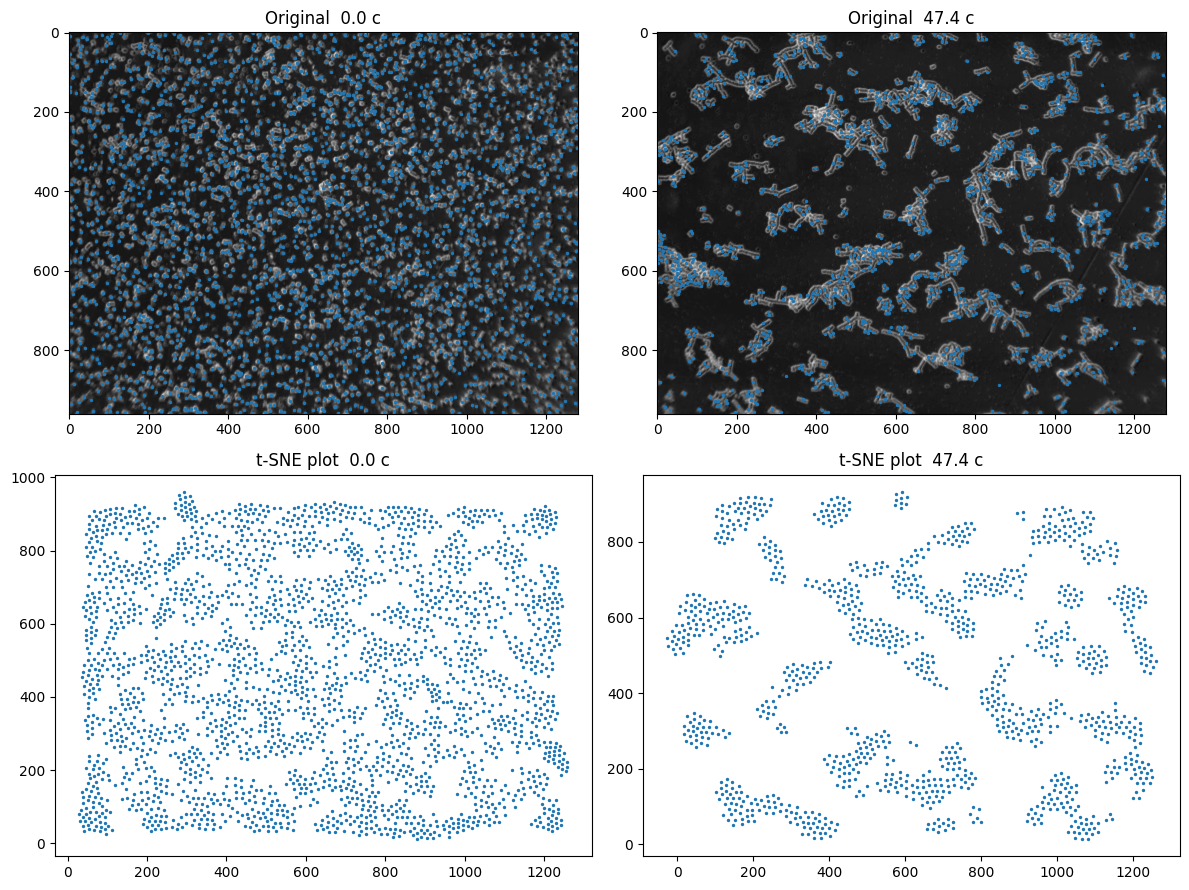

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

cap = cv2.VideoCapture("1.mp4")
fps = float(cap.get(cv2.CAP_PROP_FPS))
frame_time = 1 / fps
imgs_idx = [0, int(times[mask_max_idx] / frame_time)]
imgs = get_frames(cap, imgs_idx)
factor = masks[0].shape[1] / imgs[0][0].shape[1]

for i, mask_idx in enumerate([0, mask_max_idx]):
    mask = masks[mask_idx]
    coords = mask2center_coords(mask)

    axs[0][i].set_title(f"Original {times[mask_idx] : .1f} с")
    axs[0][i].imshow(imgs[i][0], cmap='gray')
    axs[0][i].scatter(coords[:, 0] / factor, coords[:, 1] / factor, s=2)

    model = manifold.TSNE(
        n_components=2,
        init=coords,  # often use as a reasonable approximation
        perplexity=40,  # important parameter
        verbose=0,
        learning_rate="auto",
    )

    coords = model.fit_transform(coords)

    axs[1][i].set_title(f"t-SNE plot {times[mask_idx] : .1f} с")
    axs[1][i].scatter(coords[:, 0], coords[:, 1], s=2)

plt.tight_layout()
plt.show()

In [ ]:
coords2 = [mask2center_coords(masks[0]), mask2center_coords(masks[mask_max_idx])]

In [ ]:
cap = cv2.VideoCapture("1.mp4")
fps = float(cap.get(cv2.CAP_PROP_FPS))
frame_time = 1 / fps
imgs_idx = [0, int(times[mask_max_idx] / frame_time)]
imgs = get_frames(cap, imgs_idx)
factor = masks[0].shape[1] / imgs[0][0].shape[1]

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2671 samples in 0.006s...
[t-SNE] Computed neighbors for 2671 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2671
[t-SNE] Computed conditional probabilities for sample 2000 / 2671
[t-SNE] Computed conditional probabilities for sample 2671 / 2671
[t-SNE] Mean sigma: 15.506406
[t-SNE] KL divergence after 250 iterations with early exaggeration: 16.147240
[t-SNE] KL divergence after 1000 iterations: 0.558402
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1240 samples in 0.001s...
[t-SNE] Computed neighbors for 1240 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1240
[t-SNE] Computed conditional probabilities for sample 1240 / 1240
[t-SNE] Mean sigma: 15.836370
[t-SNE] KL divergence after 250 iterations with early exaggeration: 14.013294
[t-SNE] KL divergence after 1000 iterations: 0.264088


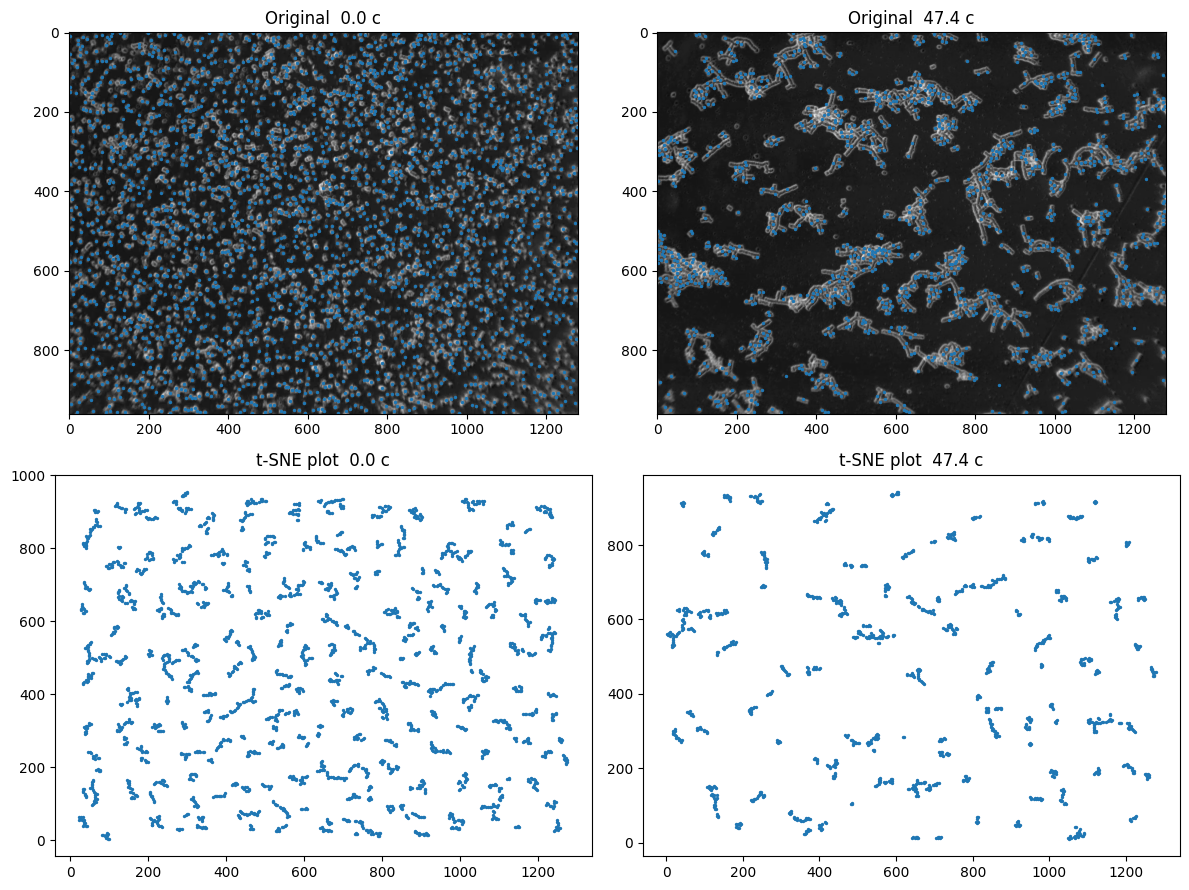

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# cap = cv2.VideoCapture("1.mp4")
# fps = float(cap.get(cv2.CAP_PROP_FPS))
# frame_time = 1 / fps
# imgs_idx = [0, int(times[mask_max_idx] / frame_time)]
# imgs = get_frames(cap, imgs_idx)
# factor = masks[0].shape[1] / imgs[0][0].shape[1]

for i, mask_idx in enumerate([0, mask_max_idx]):
    # mask = masks[mask_idx]
    # coords = mask2center_coords(mask)
    coords = coords2[i]

    axs[0][i].set_title(f"Original {times[mask_idx] : .1f} с")
    axs[0][i].imshow(imgs[i][0], cmap='gray')
    axs[0][i].scatter(coords[:, 0] / factor, coords[:, 1] / factor, s=2)

    model = manifold.TSNE(
        n_components=2,
        init=coords,  # often use as a reasonable approximation
        perplexity=5,  # important parameter
        early_exaggeration = 5,
        verbose=1,
        # min_grad_norm=1e-7,
        # learning_rate=100,
        # n_iter=250,
        # n_iter_without_progress=300,
        # method{‘barnes_hut’, ‘exact’},
    )

    coords = model.fit_transform(coords)

    axs[1][i].set_title(f"t-SNE plot {times[mask_idx] : .1f} с")
    axs[1][i].scatter(coords[:, 0], coords[:, 1], s=2)

plt.tight_layout()
plt.show()

##UMAP

In [ ]:
!pip install -q umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 886.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
from umap import UMAP

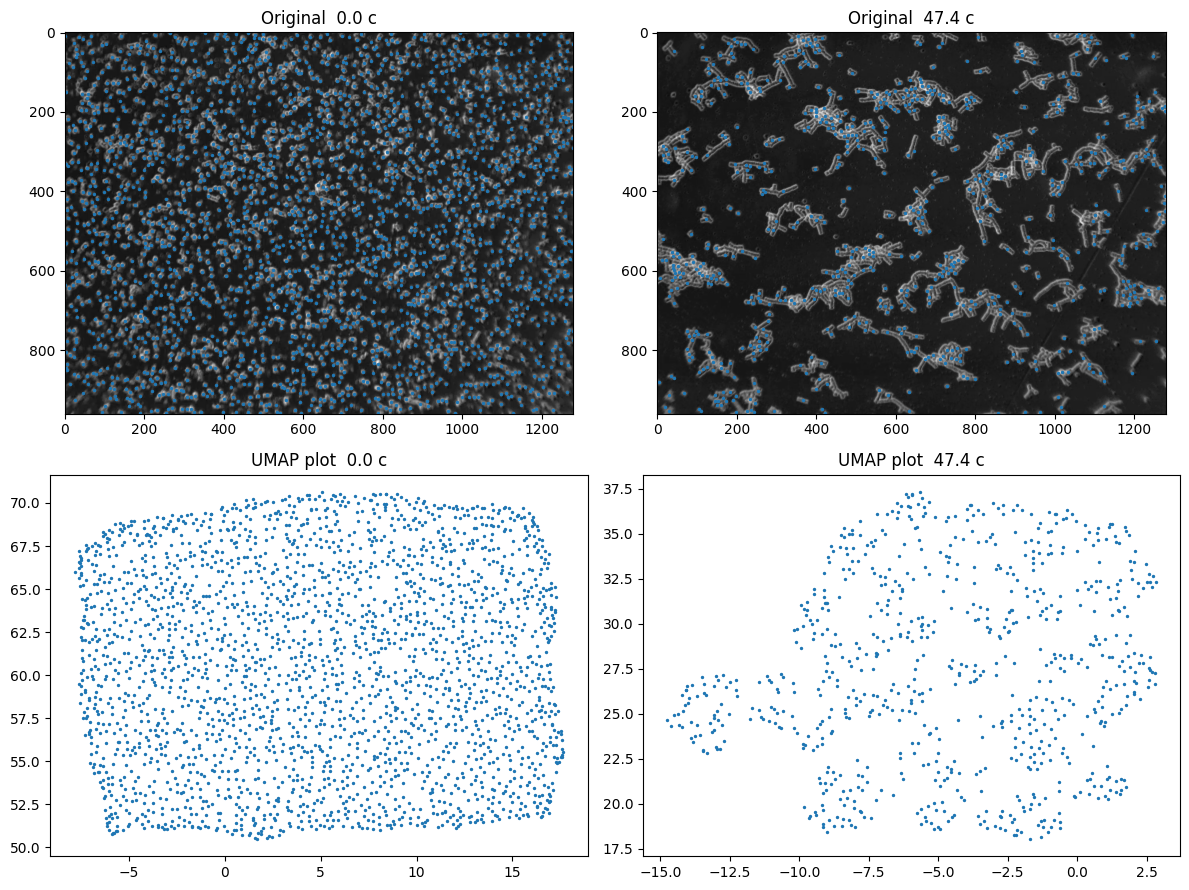

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

cap = cv2.VideoCapture("1.mp4")
fps = float(cap.get(cv2.CAP_PROP_FPS))
frame_time = 1 / fps
imgs_idx = [0, int(times[mask_max_idx] / frame_time)]
imgs = get_frames(cap, imgs_idx)

for i, mask_idx in enumerate([0, mask_max_idx]):
    mask = masks[mask_idx]
    coords = mask2center_coords(mask)

    axs[0][i].set_title(f"Original {times[mask_idx] : .1f} с")
    axs[0][i].imshow(imgs[i][0], cmap='gray')
    axs[0][i].scatter(coords[:, 0] / 1.7, coords[:, 1] / 1.7, s=2)

    model = UMAP(
        n_components=2,
        min_dist=1,
        n_neighbors=50,
        init=coords,
        # it is recommended to use the first two components of PCA for initialization of UMAP and t-SNE
        n_epochs=1000,
        verbose=0,
    )

    # Runs the UMAP algorithm on the PCA transformed data
    coords = model.fit_transform(coords)

    axs[1][i].set_title(f"UMAP plot {times[mask_idx] : .1f} с")
    axs[1][i].scatter(coords[:, 0], coords[:, 1], s=2)

plt.tight_layout()
plt.show()

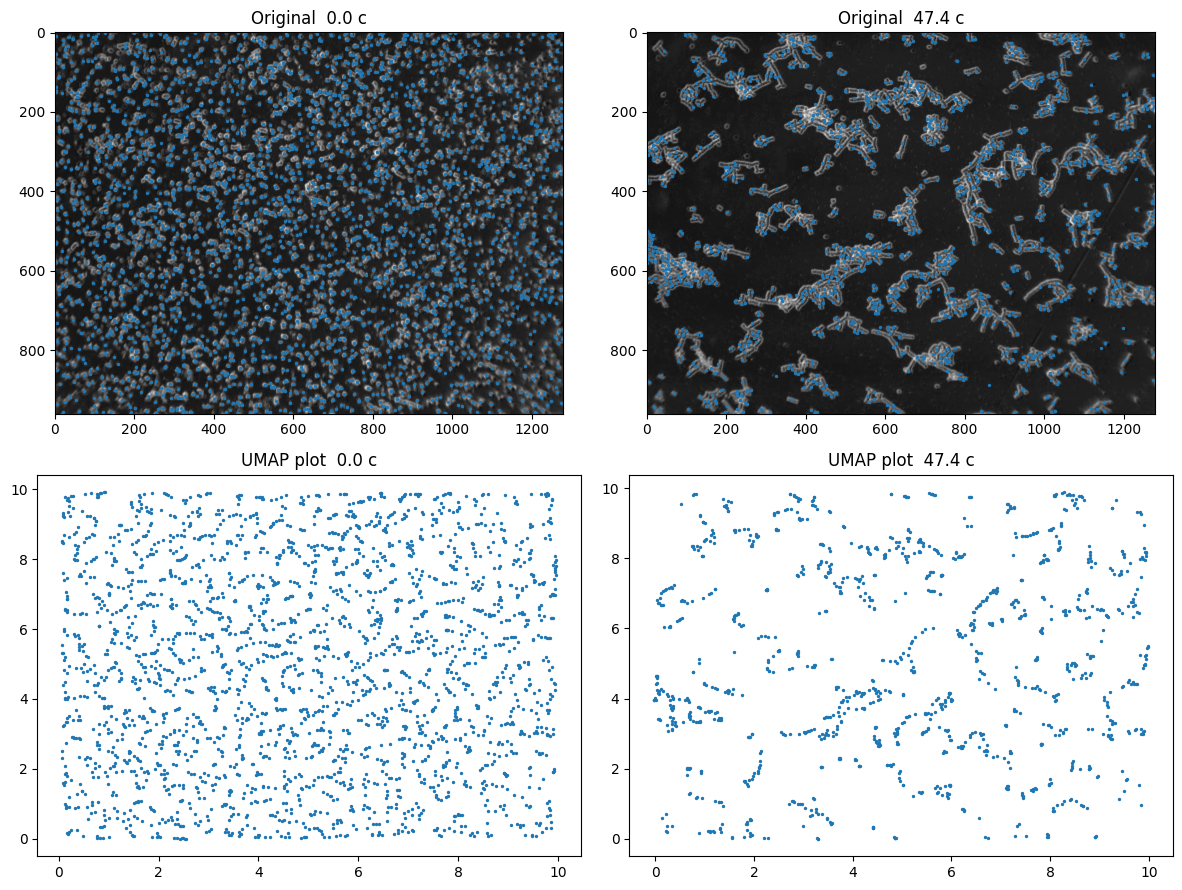

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

umap_coords = []

for i, mask_idx in enumerate([0, mask_max_idx]):
    # mask = masks[mask_idx]
    # coords = mask2center_coords(mask)
    coords = coords2[i]

    axs[0][i].set_title(f"Original {times[mask_idx] : .1f} с")
    axs[0][i].imshow(imgs[i][0], cmap='gray')
    axs[0][i].scatter(coords[:, 0], coords[:, 1], s=2)

    model = UMAP(
        n_components=2,
        min_dist=0.01,
        # spread=100,
        n_neighbors=5,
        learning_rate=0.01,
        # local_connectivity=2
        init=coords,
        # it is recommended to use the first two components of PCA for initialization of UMAP and t-SNE
        n_epochs=10,
        verbose=0,
    )

    # Runs the UMAP algorithm on the PCA transformed data
    coords = model.fit_transform(coords)
    max_num = coords[:, 1].max()
    coords[:, 1] = max_num - coords[:, 1] # надо перевернуть изображение
    umap_coords.append(coords)

    axs[1][i].set_title(f"UMAP plot {times[mask_idx] : .1f} с")
    axs[1][i].scatter(coords[:, 0], coords[:, 1], s=2)

plt.tight_layout()
plt.show()

In [ ]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


###DBSCAN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN


def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    np.random.shuffle(colors)
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    # proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            # ax.plot(
            #     X[ci, 0],
            #     X[ci, 1],
            #     "x" if k == -1 else "o",
            #     markerfacecolor=tuple(col),
            #     markeredgecolor="k",
            #     # markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            # )
            ax.scatter(
                X[ci, 0],
                X[ci, 1],
                color=tuple(col),
                s=2
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

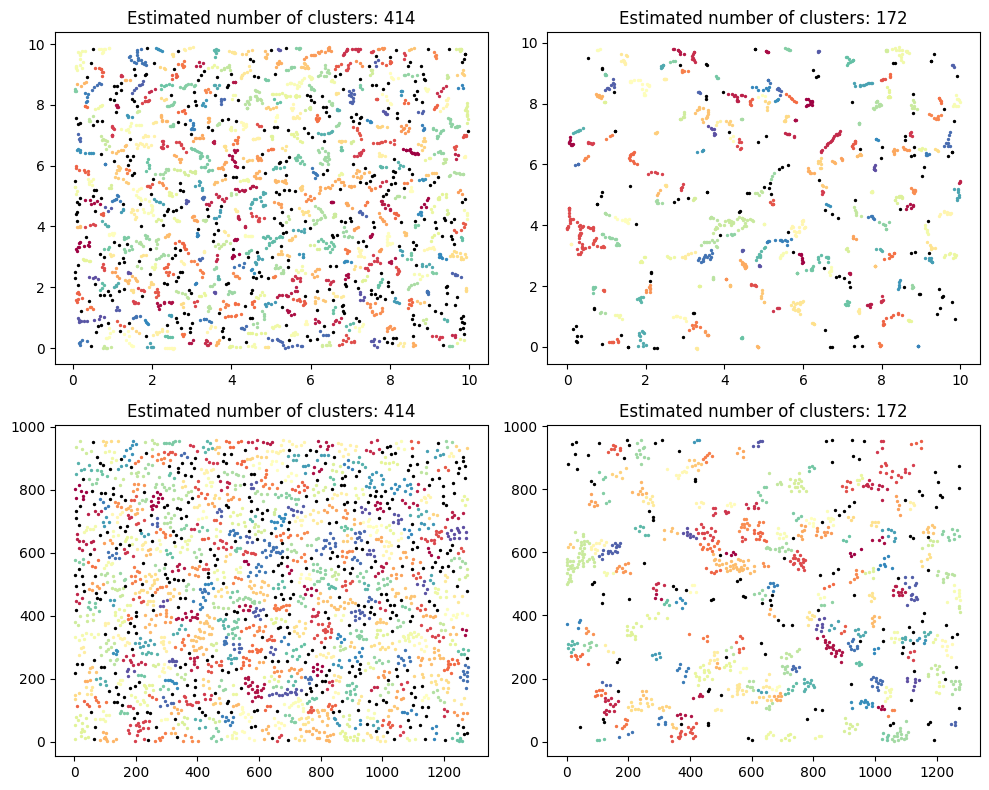

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

eps = 20 / (1280 / 10)
min_samples = 3

for i in range(2):
    dbs = DBSCAN(eps=eps, min_samples=min_samples)
    dbs.fit(umap_coords[i])
    # np.random.shuffle(dbs.labels_)
    plot(umap_coords[i], labels=dbs.labels_, ax=axs[0][i])
    plot(coords2[i], labels=dbs.labels_, ax=axs[1][i])


###HDBSCAN

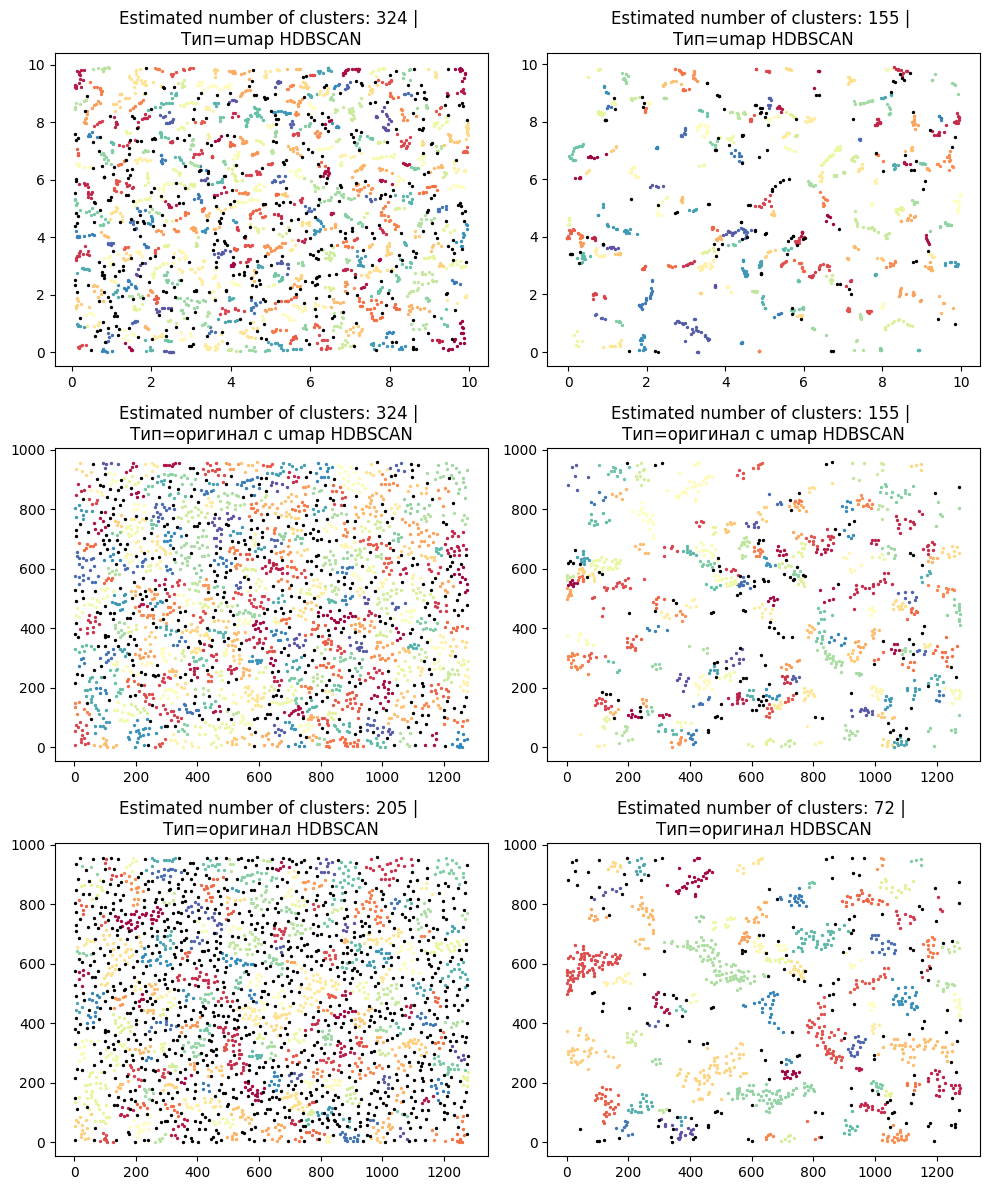

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

eps = 20 / (1280 / 10)
min_samples = 3
min_cluster_size=3

for i in range(2):
    dbs = HDBSCAN(min_cluster_size=min_cluster_size)
    dbs.fit(umap_coords[i])
    # np.random.shuffle(dbs.labels_)
    plot(umap_coords[i], labels=dbs.labels_, parameters={'\nТип' : 'umap HDBSCAN'}, ax=axs[0][i])
    plot(coords2[i], labels=dbs.labels_, parameters={'\nТип' : 'оригинал с umap HDBSCAN'}, ax=axs[1][i])
    dbs = HDBSCAN(min_cluster_size=min_cluster_size)
    dbs.fit(coords2[i])
    plot(coords2[i], labels=dbs.labels_, parameters={'\nТип' : 'оригинал HDBSCAN'}, ax=axs[2][i])

###Все видео

In [ ]:
av_num_in_clusters = np.zeros_like(times)
av_num_only_in_clusters = np.zeros_like(times)
sil_coeffs = np.zeros_like(times)

# mask_0 = masks[0]
# cells_number = mask_0.max()
# cells_area = (mask_0 != 0).sum()
# cell_area = cells_area / cells_number
# diam = np.sqrt(cell_area / np.pi)

eps = 20 / (1280 / 10)
min_samples = 3

for i in trange(0, mask_max_idx + 1):
    coords = mask2center_coords(masks[i])

    model = UMAP(
        n_components=2,
        min_dist=0.01,
        # spread=100,
        n_neighbors=5,
        learning_rate=0.01,
        # local_connectivity=2
        init=coords,
        # it is recommended to use the first two components of PCA for initialization of UMAP and t-SNE
        n_epochs=10,
        verbose=0,
    )

    # Runs the UMAP algorithm on the PCA transformed data
    coords = model.fit_transform(coords)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(coords)
    labels = db.labels_
    unique_labels = set(labels)

    # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1) # эти клетки тоже важно учесть

    num_in_clusters = 0
    cluster_count = 0
    for label in unique_labels:
        if label == -1:
            continue
        cells_in_claster = (labels == label).sum()
        num_in_clusters += cells_in_claster
        cluster_count += 1
    av_num_in_clusters[i] = (num_in_clusters + n_noise_) / (cluster_count + n_noise_)
    av_num_only_in_clusters[i] = num_in_clusters / cluster_count

    sil_coeff = 0
    if len(unique_labels) > 1:
        sil_coeff = metrics.silhouette_score(coords, labels)
    sil_coeffs[i] = sil_coeff

  0%|          | 0/285 [00:00<?, ?it/s]

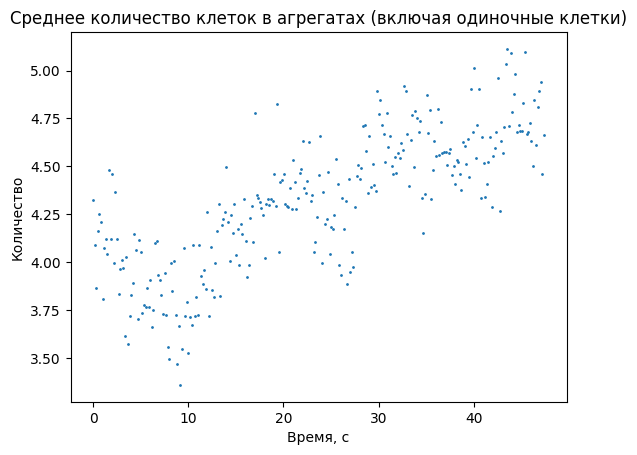

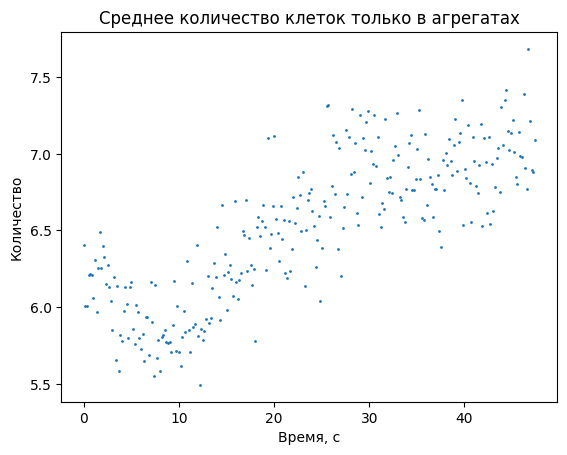

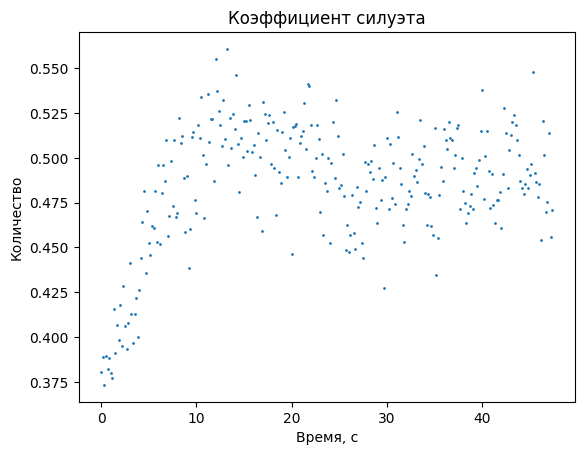

In [ ]:
plt.scatter(times, av_num_in_clusters, s=1)
plt.title("Среднее количество клеток в агрегатах (включая одиночные клетки)")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.show()

plt.scatter(times, av_num_only_in_clusters, s=1)
plt.title("Среднее количество клеток только в агрегатах")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.show()

plt.scatter(times, sil_coeffs, s=1)
plt.title("Коэффициент силуэта")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.show()

##AgglomerativeClustering

[AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)

##HDBSCAN

[HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html#sklearn.cluster.HDBSCAN)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN


def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    np.random.shuffle(colors)
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    # proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            # ax.plot(
            #     X[ci, 0],
            #     X[ci, 1],
            #     "x" if k == -1 else "o",
            #     markerfacecolor=tuple(col),
            #     markeredgecolor="k",
            #     # markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            # )
            ax.scatter(
                X[ci, 0],
                X[ci, 1],
                color=tuple(col),
                s=2
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

In [ ]:
coords3 = [mask2center_coords(masks[0]), mask2center_coords(masks[int(mask_max_idx / 3)]), mask2center_coords(masks[mask_max_idx])]

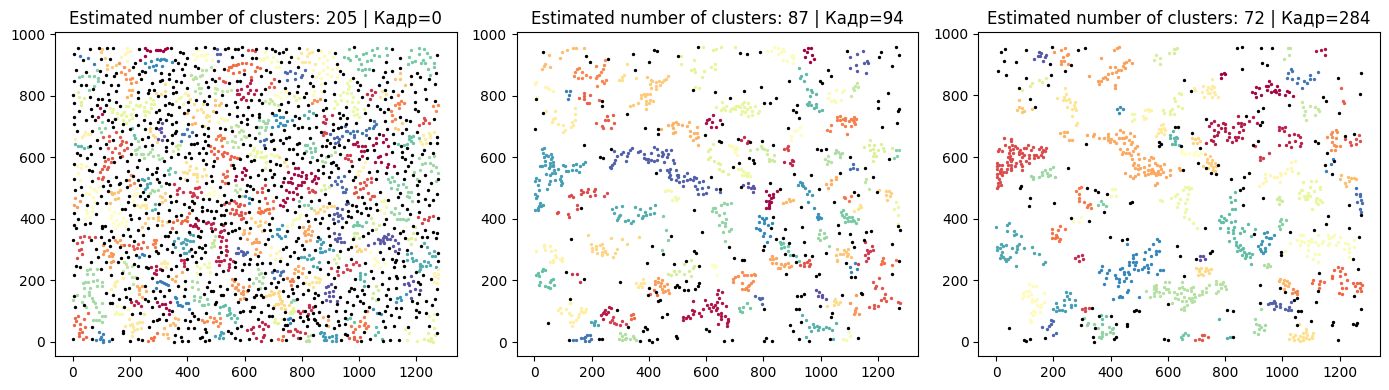

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

min_cluster_size=3

for i, snip in enumerate([0,int(mask_max_idx / 3), mask_max_idx]):
    dbs = HDBSCAN(min_cluster_size=min_cluster_size)
    dbs.fit(coords3[i])
    plot(coords3[i], labels=dbs.labels_, parameters={'Кадр' : snip}, ax=axs[i])

In [ ]:
for i, snip in enumerate([0,int(mask_max_idx / 3), mask_max_idx]):
    coords = coords3[i]

    dbs = HDBSCAN(min_cluster_size=min_cluster_size)
    dbs.fit(coords)

    labels = dbs.labels_
    unique_labels = set(labels)

    # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1) # эти клетки тоже важно учесть

    num_in_clusters_tmp = 0
    cluster_count = 0
    length_of_clusters = 0
    for label in unique_labels:
        if label == -1:
            continue
        cells_in_claster = (labels == label).sum()
        num_in_clusters_tmp += cells_in_claster
        cluster_count += 1

        claster_labels = labels == label
        cluster_coords = coords[claster_labels]
        dist_mat = spatial.distance_matrix(cluster_coords, cluster_coords)
        i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
        length_of_clusters += spatial.distance.pdist([cluster_coords[i], cluster_coords[j]])[0]
    print('Кадр', snip)
    print('av_len_of_clasters', length_of_clusters / cluster_count)
    print('num_in_clusters', num_in_clusters_tmp)
    print('num_not_in_clusters', n_noise_)
    print('num_of_clusters', cluster_count)
    print('av_num_in_clusters', (num_in_clusters_tmp + n_noise_) / (cluster_count + n_noise_))
    print('av_num_only_in_clusters', num_in_clusters_tmp / cluster_count)

Кадр 0
av_len_of_clasters 55.86388883482751
num_in_clusters 1694
num_not_in_clusters 977
num_of_clusters 205
av_num_in_clusters 2.259729272419628
av_num_only_in_clusters 8.263414634146342
Кадр 94
av_len_of_clasters 77.39395388930967
num_in_clusters 1028
num_not_in_clusters 208
num_of_clusters 87
av_num_in_clusters 4.189830508474576
av_num_only_in_clusters 11.816091954022989
Кадр 284
av_len_of_clasters 84.18395462617185
num_in_clusters 1080
num_not_in_clusters 160
num_of_clusters 72
av_num_in_clusters 5.344827586206897
av_num_only_in_clusters 15.0


###Все видео

In [ ]:
from scipy import spatial

In [ ]:
av_num_in_clusters = np.zeros_like(times)
av_num_only_in_clusters = np.zeros_like(times)
num_in_clusters = np.zeros_like(times)
num_not_in_clusters = np.zeros_like(times)
num_of_clusters = np.zeros_like(times)
av_len_of_clasters = np.zeros_like(times)
sil_coeffs = np.zeros_like(times)
calinski_hrabasz_index = np.zeros_like(times)

min_cluster_size=3

for i in trange(0, mask_max_idx + 1):
    coords = mask2center_coords(masks[i])

    dbs = HDBSCAN(min_cluster_size=min_cluster_size)
    dbs.fit(coords)
    labels = dbs.labels_
    unique_labels = set(labels)

    # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1) # эти клетки тоже важно учесть

    num_in_clusters_tmp = 0
    cluster_count = 0
    length_of_clusters = 0
    for label in unique_labels:
        if label == -1:
            continue
        cells_in_claster = (labels == label).sum()
        num_in_clusters_tmp += cells_in_claster
        cluster_count += 1

        claster_labels = labels == label
        cluster_coords = coords[claster_labels]
        dist_mat = spatial.distance_matrix(cluster_coords, cluster_coords)
        с1, с2 = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
        length_of_clusters += spatial.distance.pdist([cluster_coords[с1], cluster_coords[с2]])[0]
    av_len_of_clasters[i] = length_of_clusters / cluster_count
    num_in_clusters[i] = num_in_clusters_tmp
    num_not_in_clusters[i] = n_noise_
    num_of_clusters[i] = cluster_count
    av_num_in_clusters[i] = (num_in_clusters_tmp + n_noise_) / (cluster_count + n_noise_)
    av_num_only_in_clusters[i] = num_in_clusters_tmp / cluster_count

    if len(unique_labels) > 1:
        sil_coeffs[i] = metrics.silhouette_score(coords, labels)
        calinski_hrabasz_index[i] = metrics.calinski_harabasz_score(coords, labels)

  0%|          | 0/285 [00:00<?, ?it/s]

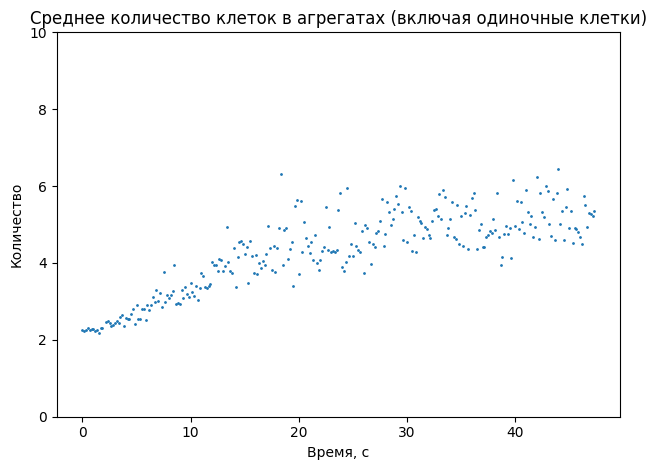

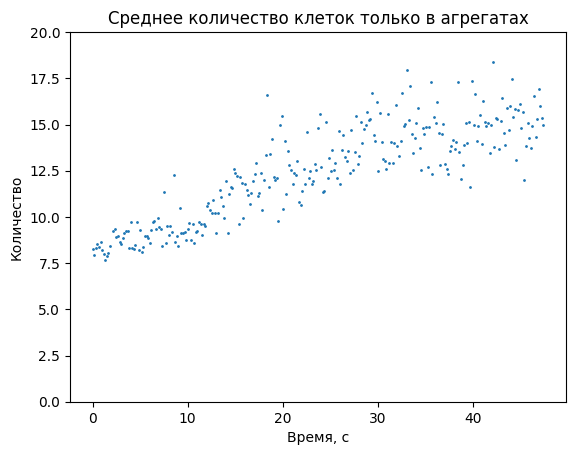

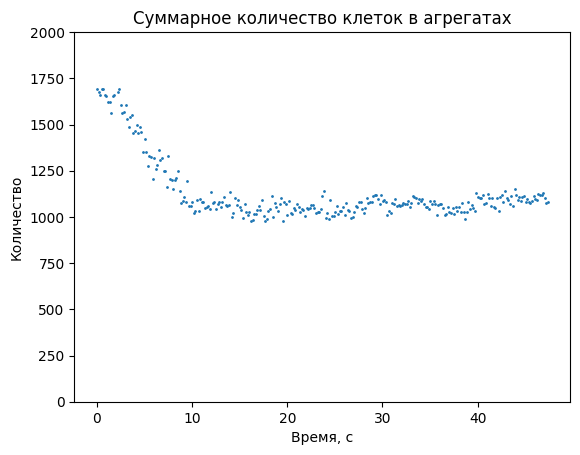

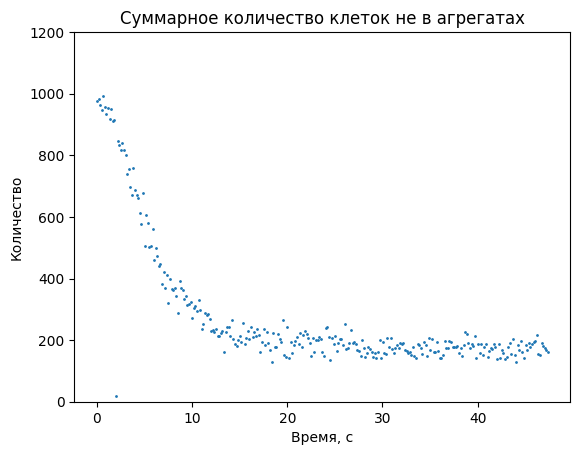

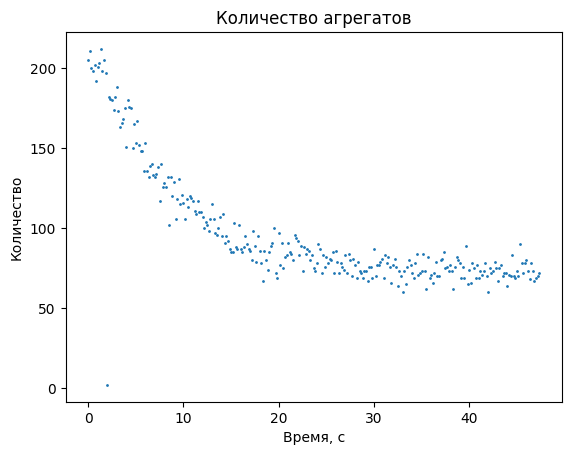

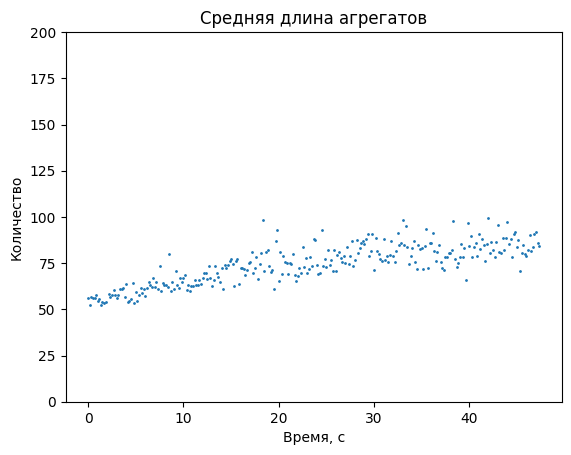

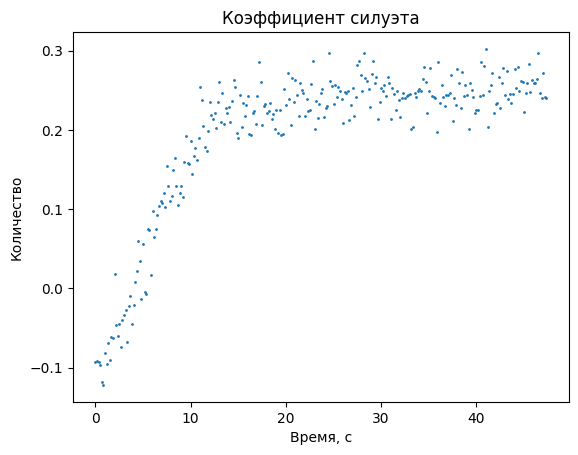

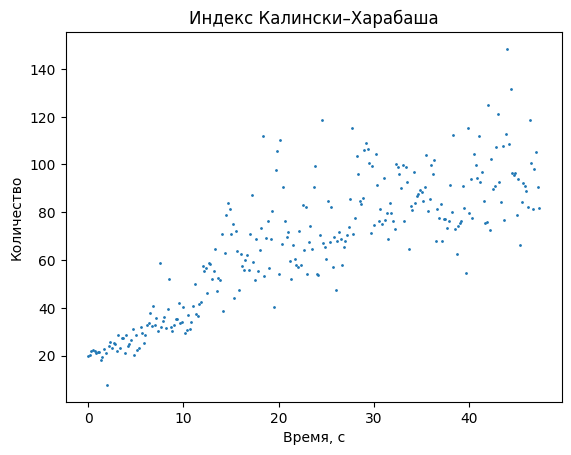

In [ ]:
plt.scatter(times, av_num_in_clusters, s=1)
plt.title("Среднее количество клеток в агрегатах (включая одиночные клетки)")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.ylim([0, 10])
plt.show()

plt.scatter(times, av_num_only_in_clusters, s=1)
plt.title("Среднее количество клеток только в агрегатах")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.ylim([0, 20])
plt.show()

plt.scatter(times, num_in_clusters, s=1)
plt.title("Суммарное количество клеток в агрегатах")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.ylim([0, 2000])
plt.show()

plt.scatter(times, num_not_in_clusters, s=1)
plt.title("Суммарное количество клеток не в агрегатах")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.ylim([0, 1200])
plt.show()

plt.scatter(times, num_of_clusters, s=1)
plt.title("Количество агрегатов")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.show()

plt.scatter(times, av_len_of_clasters, s=1)
plt.title("Средняя длина агрегатов")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.ylim([0, 200])
plt.show()

plt.scatter(times, sil_coeffs, s=1)
plt.title("Коэффициент силуэта")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.show()

plt.scatter(times, calinski_hrabasz_index, s=1)
plt.title("Индекс Калински–Харабаша")
plt.xlabel("Время, с")
plt.ylabel("Количество")
plt.show()

##OPTICS

[OPTICS](https://scikit-learn.org/stable/modules/clustering.html#optics)

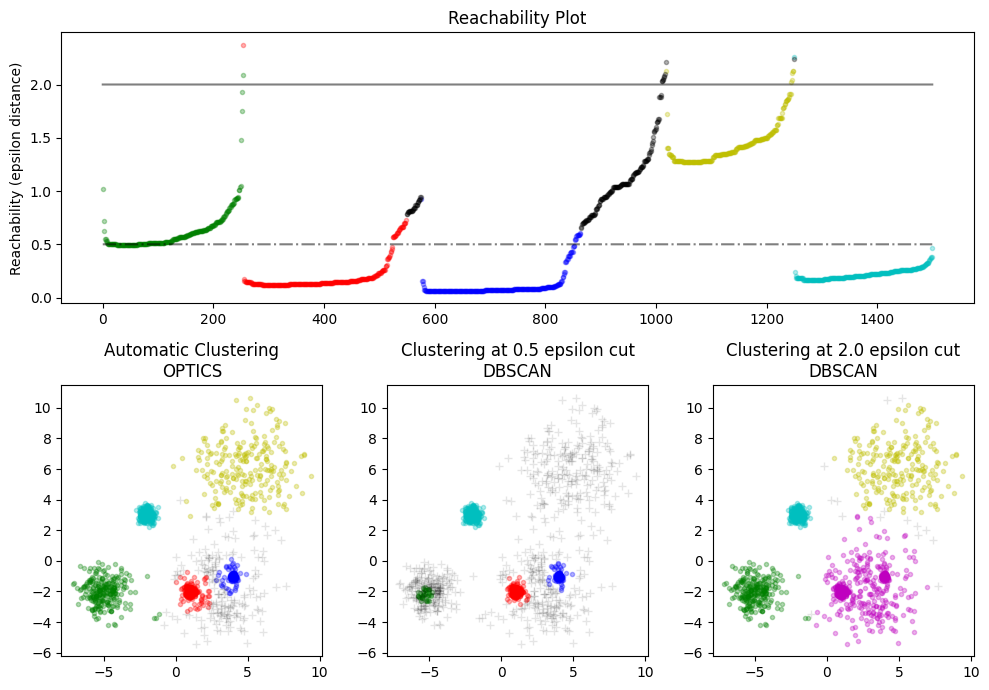

In [ ]:
# Authors: Shane Grigsby <refuge@rocktalus.com>
#          Adrin Jalali <adrin.jalali@gmail.com>
# License: BSD 3 clause

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import OPTICS, cluster_optics_dbscan

# Generate sample data

np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + 0.8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + 0.1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + 0.2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + 0.3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

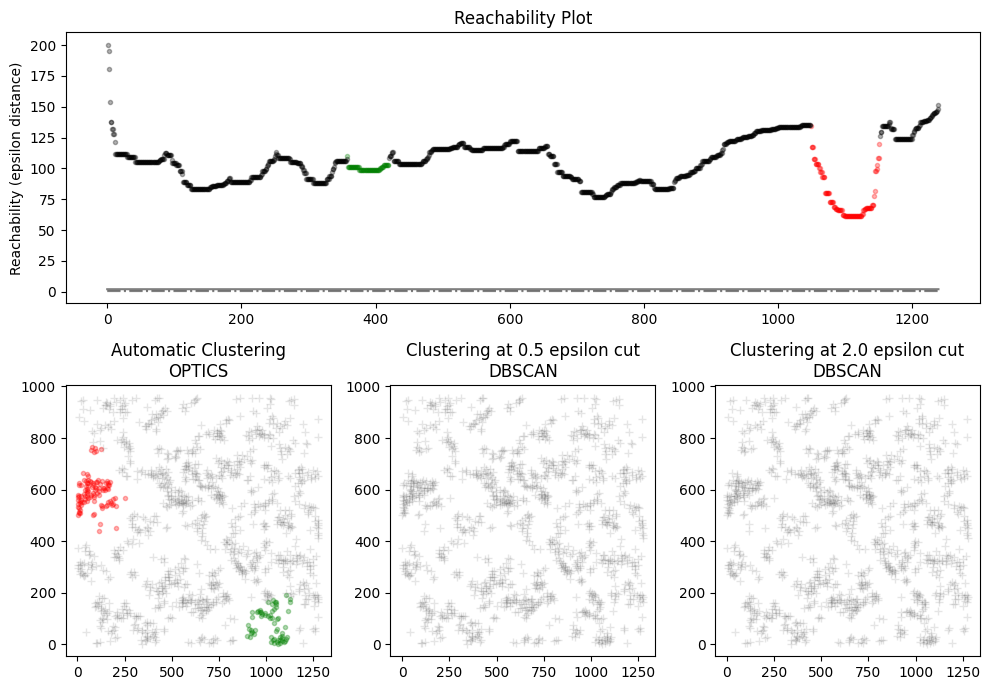

In [ ]:
min_samples=50
xi=0.05
min_cluster_size=0.05

clust = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
X = coords3[2]
clust.fit(X)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=20,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=30,
)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

##Birch

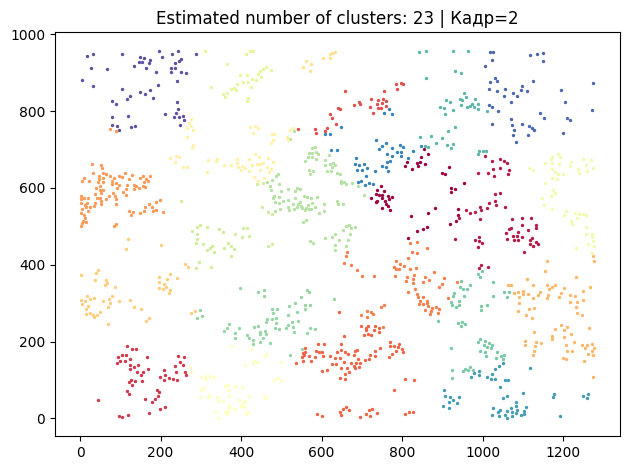

In [ ]:
from sklearn.cluster import Birch

X = coords3[2]
brc = Birch(n_clusters=None, threshold=100, branching_factor=300)
brc.fit(X)
brc.predict(X)

fig, ax = plt.subplots()
plot(coords3[i], labels=brc.labels_, parameters={'Кадр' : i}, ax=ax)
plt.show()

#Дообучение модели